In [97]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 
import seaborn as sns
# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.calibration import calibration_curve

# learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.1.1
numpy         Tested version: 1.21.5  Your version: 1.26.2
matplotlib    Tested version: 3.5.3   Your version: 3.8.0
scikit-learn  Tested version: 1.2.2   Your version: 1.6.1


In [98]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [99]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.7  # maximum percentage of missing values for a column to be dropped

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin

In [101]:
class DropHighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_drop = None

    def fit(self, X, y=None):
        # Calculate the correlation matrix
        X = pd.DataFrame(X)
        corr_matrix = X.corr()

        # Find pairs of features that are highly correlated
        highly_correlated = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if (corr_matrix.loc[i, j] > self.threshold) and (i != j)]

        # Remove one feature from each highly correlated pair
        self.features_to_drop = set()
        for i, j in highly_correlated:
            if i not in self.features_to_drop and j not in self.features_to_drop:
                self.features_to_drop.add(j)

        return self

    def transform(self, X):
        # Drop the highly correlated features
        X = pd.DataFrame(X)
        X_reduced = X.drop(columns=self.features_to_drop)
        return X_reduced

    def get_feature_names_out(self, input_features=None):
        new_features = []
        for i, feature in enumerate(input_features):
            if i not in self.features_to_drop:
                new_features.append(feature)
        return np.array(new_features)

In [102]:
description_dict

{'encounter_id': {'Category': 'identifier',
  'Unit of Measure': nan,
  'Data Type': 'integer',
  'Description': 'Unique identifier associated with a patient unit stay',
  'Example': nan},
 'hospital_id': {'Category': 'identifier',
  'Unit of Measure': nan,
  'Data Type': 'integer',
  'Description': 'Unique identifier associated with a hospital',
  'Example': nan},
 'patient_id': {'Category': 'identifier',
  'Unit of Measure': nan,
  'Data Type': 'integer',
  'Description': 'Unique identifier associated with a patient',
  'Example': nan},
 'hospital_death': {'Category': 'demographic',
  'Unit of Measure': nan,
  'Data Type': 'binary',
  'Description': 'Whether the patient died during this hospitalization',
  'Example': '0'},
 'age': {'Category': 'demographic',
  'Unit of Measure': 'Years',
  'Data Type': 'numeric',
  'Description': 'The age of the patient on unit admission',
  'Example': nan},
 'bmi': {'Category': 'demographic',
  'Unit of Measure': 'kilograms/metres^2',
  'Data Type':

In [103]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem', # drop because of similarity with apache_3j_bodysystem
                    # "ethnicity" # Check if can be dropped
                    ],
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("drop_correlated", DropHighlyCorrelatedFeatures(threshold=0.8)),
                                  ("imputer", SimpleImputer(strategy="mean")),
                                  ("scaling", RobustScaler(quantile_range=(10, 90))),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")),
    ("constant", VarianceThreshold())
    ])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])

prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # display preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('drop_correlated',
                                                  DropHighlyCorrelatedFeatures()),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaling',
                                                  RobustScaler(quantile_range=(10,
                                                                               90)))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F82A1FA1D0>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('constant',
                                                  VarianceThreshold())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F82A1F81D0>)])

Time: 3.63s
Train set: 73370 rows, 117 columns
Validation set: 9171 rows, 117 columns
Test set: 9172 rows, 117 columns


In [104]:
X_train.columns


Index(['num__age', 'num__bmi', 'num__elective_surgery', 'num__height',
       'num__pre_icu_los_days', 'num__albumin_apache',
       'num__apache_2_diagnosis', 'num__apache_3j_diagnosis',
       'num__arf_apache', 'num__bilirubin_apache',
       ...
       'cat__apache_3j_bodysystem_Genitourinary',
       'cat__apache_3j_bodysystem_Gynecological',
       'cat__apache_3j_bodysystem_Hematological',
       'cat__apache_3j_bodysystem_MISSING',
       'cat__apache_3j_bodysystem_Metabolic',
       'cat__apache_3j_bodysystem_Musculoskeletal/Skin',
       'cat__apache_3j_bodysystem_Neurological',
       'cat__apache_3j_bodysystem_Respiratory',
       'cat__apache_3j_bodysystem_Sepsis', 'cat__apache_3j_bodysystem_Trauma'],
      dtype='object', length=117)

In [105]:
X_train

,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__albumin_apache,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__arf_apache,num__bilirubin_apache,...,cat__apache_3j_bodysystem_Genitourinary,cat__apache_3j_bodysystem_Gynecological,cat__apache_3j_bodysystem_Hematological,cat__apache_3j_bodysystem_MISSING,cat__apache_3j_bodysystem_Metabolic,cat__apache_3j_bodysystem_Musculoskeletal/Skin,cat__apache_3j_bodysystem_Neurological,cat__apache_3j_bodysystem_Respiratory,cat__apache_3j_bodysystem_Sepsis,cat__apache_3j_bodysystem_Trauma
0,0.522727,0.007552,0.0,0.007168,-0.061876,0.00000,0.917526,-0.001664,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.204545,0.465032,0.0,0.003584,-0.022076,0.00000,0.005155,-0.087792,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.613636,-0.030776,0.0,-0.265233,-0.041976,0.00000,-0.005155,0.244998,0.00000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.068182,-0.327022,0.0,0.394265,0.033581,0.00000,0.938144,0.410548,0.00000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.818182,-0.436020,0.0,0.279570,-0.038556,-0.40288,-0.051546,0.076111,0.00000,-1.133078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,-1.068182,-0.305333,1.0,-0.175627,-0.060011,0.00000,0.494845,0.914733,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73366,0.159091,0.078142,1.0,0.358423,0.189049,0.00000,0.321833,-0.342606,0.00000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73367,0.204545,0.151199,1.0,0.609319,0.044153,0.00000,0.407216,0.664710,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73368,-0.386364,1.799951,0.0,-0.086022,-0.061876,0.49712,-0.108247,-0.170567,0.00000,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [106]:
print(list(X_test.columns))

['num__age', 'num__bmi', 'num__elective_surgery', 'num__height', 'num__pre_icu_los_days', 'num__albumin_apache', 'num__apache_2_diagnosis', 'num__apache_3j_diagnosis', 'num__arf_apache', 'num__bilirubin_apache', 'num__bun_apache', 'num__creatinine_apache', 'num__gcs_eyes_apache', 'num__gcs_motor_apache', 'num__gcs_unable_apache', 'num__gcs_verbal_apache', 'num__glucose_apache', 'num__heart_rate_apache', 'num__hematocrit_apache', 'num__intubated_apache', 'num__map_apache', 'num__resprate_apache', 'num__sodium_apache', 'num__temp_apache', 'num__urineoutput_apache', 'num__ventilated_apache', 'num__wbc_apache', 'num__d1_diasbp_max', 'num__d1_diasbp_min', 'num__d1_heartrate_min', 'num__d1_resprate_max', 'num__d1_resprate_min', 'num__d1_spo2_max', 'num__d1_spo2_min', 'num__d1_sysbp_max', 'num__d1_sysbp_min', 'num__d1_temp_max', 'num__d1_temp_min', 'num__h1_diasbp_max', 'num__h1_diasbp_min', 'num__h1_heartrate_max', 'num__h1_resprate_max', 'num__h1_resprate_min', 'num__h1_spo2_max', 'num__h1_

In [107]:
X_train.columns

Index(['num__age', 'num__bmi', 'num__elective_surgery', 'num__height',
       'num__pre_icu_los_days', 'num__albumin_apache',
       'num__apache_2_diagnosis', 'num__apache_3j_diagnosis',
       'num__arf_apache', 'num__bilirubin_apache',
       ...
       'cat__apache_3j_bodysystem_Genitourinary',
       'cat__apache_3j_bodysystem_Gynecological',
       'cat__apache_3j_bodysystem_Hematological',
       'cat__apache_3j_bodysystem_MISSING',
       'cat__apache_3j_bodysystem_Metabolic',
       'cat__apache_3j_bodysystem_Musculoskeletal/Skin',
       'cat__apache_3j_bodysystem_Neurological',
       'cat__apache_3j_bodysystem_Respiratory',
       'cat__apache_3j_bodysystem_Sepsis', 'cat__apache_3j_bodysystem_Trauma'],
      dtype='object', length=117)

# 3. Modeling

### Functions to be used in the different models

The following section starts with creating several functions, such as the creation of Calibration and confusion matrix plots and metrics.

In [108]:
def plotCFMatrix(cm): # input is the confusion matrix from sklearn
    
    plt.figure(figsize=(8, 6))  
    sns.set_style("whitegrid") 
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [109]:
def Metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'TPR: {tpr}')
    print(f'TNR: {tnr}')
    return accuracy, precision, recall, f1, tpr, tnr

In [110]:
def calibration_plot(y_true, y_prob, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot - {model_name}')
    plt.legend()
    plt.show()

## Model Selection

### Logistic Regression
Firstly logistic regression is used.

In [111]:
lr = LogisticRegression(penalty="l1", solver="saga")
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)
lr_pred_proba = lr.predict_proba(X_val)[:, 1]


c:\Users\daanr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [112]:
cm_lr = confusion_matrix(y_val, lr_pred)
accuracy_lr, precision_lr, recall_lr, f1_lr, tpr_lr, tnr_lr = Metrics(y_val, lr_pred)

Accuracy: 0.92
Precision: 0.62
Recall: 0.25
F1 Score: 0.36
TPR: 0.2537688442211055
TNR: 0.9851940298507462


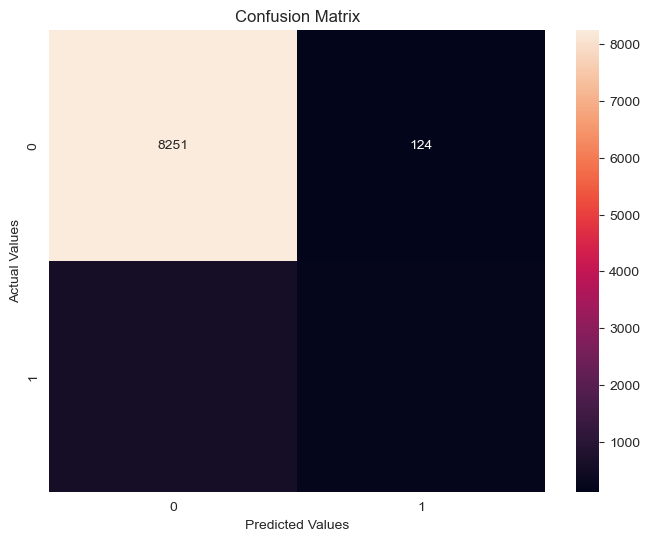

In [113]:
plotCFMatrix(cm_lr)

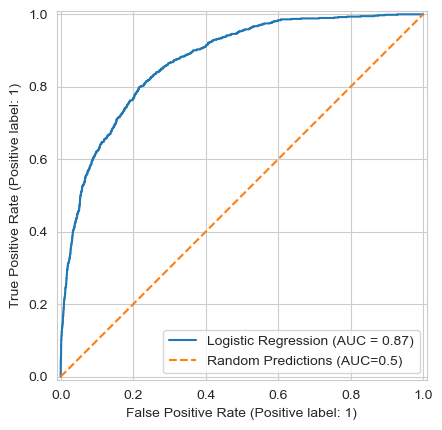

In [114]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=lr_pred_proba, name='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

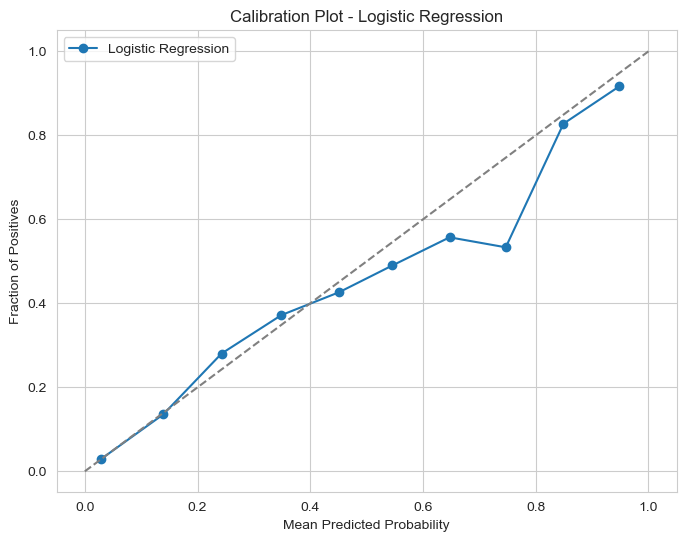

In [115]:
calibration_plot(y_val, lr_pred_proba, "Logistic Regression")

### Random Forest Classifier
This classifier uses weights, class 0 is the no hospital death class and receives the standard weight of 1. class 1 the hospital death class is very important to correctly identify, thus it receives a higher weight.

In [116]:
class_weights_rf = {0: 1,    # Class 0 with weight 1
                 1: 2}       # Class 1 with higher weight 2

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights_rf, max_depth=10)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_pred_proba = rf.predict_proba(X_val)[:, 1]


In [117]:
cm_rf = confusion_matrix(y_val, rf_pred)
accuracy_rf, precision_rf, recall_rf, f1_rf, tpr_rf, tnr_rf = Metrics(y_val, rf_pred)

Accuracy: 0.93
Precision: 0.69
Recall: 0.26
F1 Score: 0.37
TPR: 0.2550251256281407
TNR: 0.9892537313432835


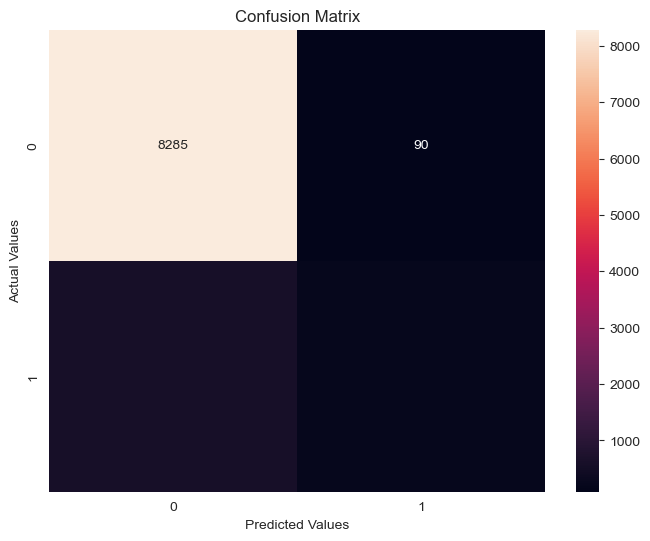

In [118]:
plotCFMatrix(cm_rf)

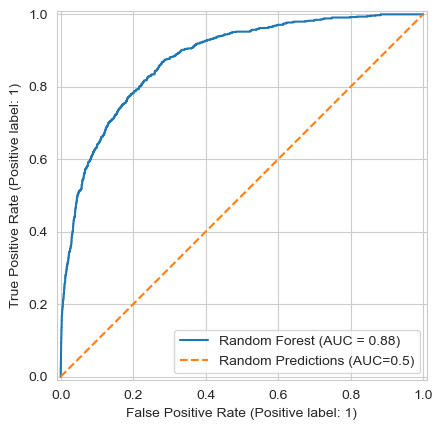

In [119]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=rf_pred_proba, name='Random Forest')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

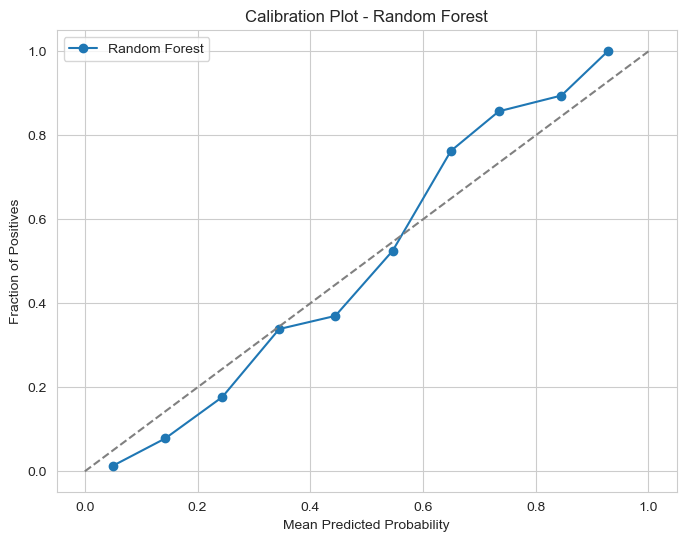

In [120]:
calibration_plot(y_val, rf_pred_proba, "Random Forest")

### Decision tree


In [121]:
dt_class_weights = {0: 1,
                    1: 2}

dt = DecisionTreeClassifier(class_weight=dt_class_weights, max_depth=5)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)
dt_pred_proba = dt.predict_proba(X_val)[:, 1]

In [122]:
cm_dt = confusion_matrix(y_val, dt_pred)
accuracy_dt, precision_dt, recall_dt, f1_dt, tpr_dt, tnr_dt = Metrics(y_val, dt_pred)

Accuracy: 0.92
Precision: 0.53
Recall: 0.29
F1 Score: 0.38
TPR: 0.292713567839196
TNR: 0.9757611940298507


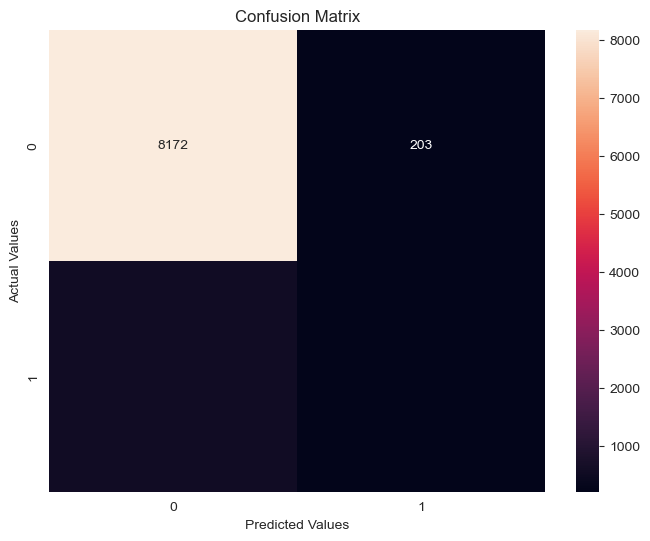

In [123]:
plotCFMatrix(cm_dt)

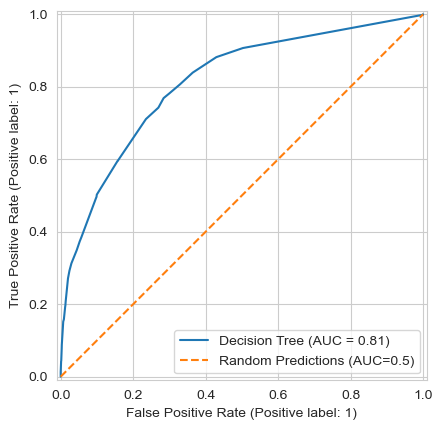

In [124]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=dt_pred_proba, name='Decision Tree')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

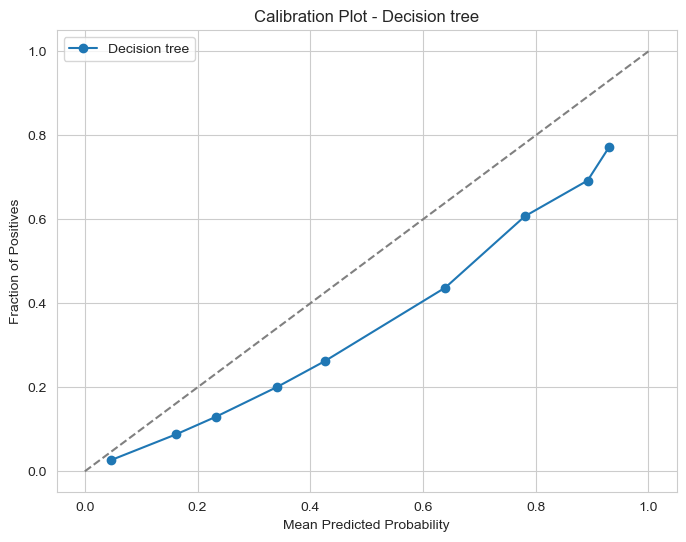

In [125]:
calibration_plot(y_val, dt_pred_proba, "Decision tree")

### XGBoost

In [126]:
xg = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=2,  
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_val)
xg_pred_proba = xg.predict_proba(X_val)[:, 1]


In [127]:
cm_xg = confusion_matrix(y_val, xg_pred)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_val, xg_pred)

Accuracy: 0.92
Precision: 0.57
Recall: 0.42
F1 Score: 0.49
TPR: 0.42336683417085424
TNR: 0.9701492537313433


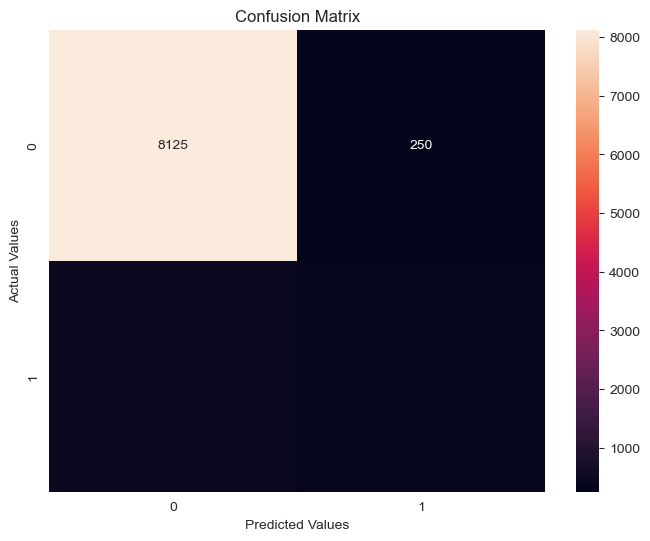

In [128]:
plotCFMatrix(cm_xg)

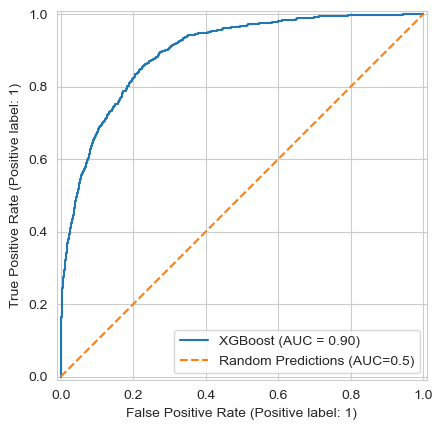

In [129]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=xg_pred_proba, name='XGBoost')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

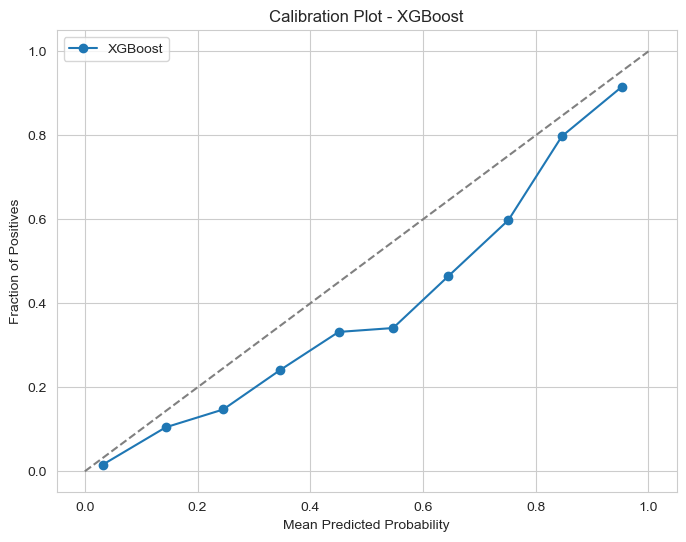

In [130]:
calibration_plot(y_val, xg_pred_proba, "XGBoost")

Top 10 most important features for XGBoost

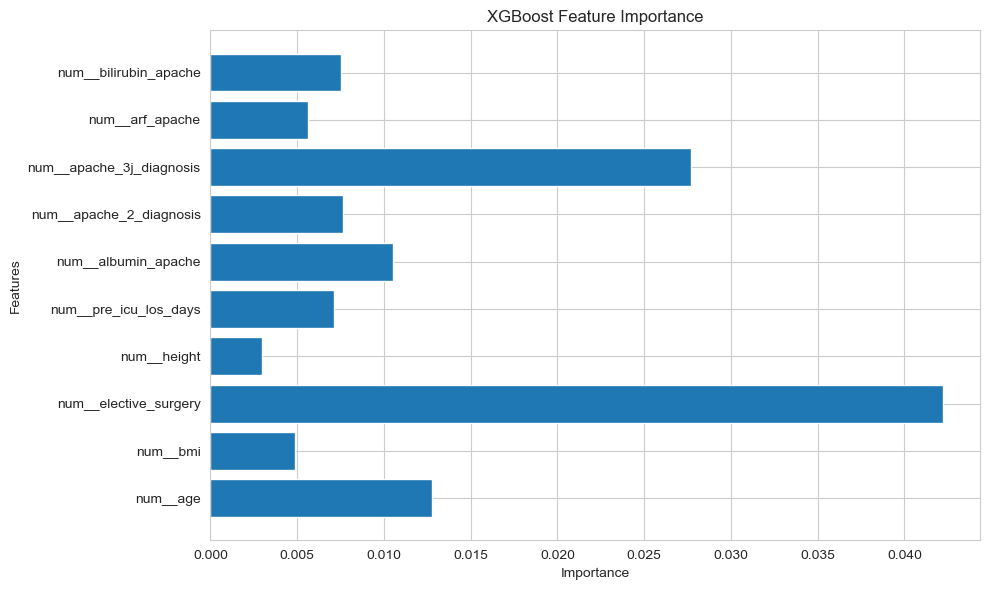

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(range(10), xg.feature_importances_[:10])
plt.yticks(range(10), X_train.columns[:10])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Logistic Regression
Accuracy: 0.92
Precision: 0.62
Recall: 0.25
F1 Score: 0.36
TPR: 0.2537688442211055
TNR: 0.9851940298507462

Decision Tree
Accuracy: 0.92
Precision: 0.53
Recall: 0.29
F1 Score: 0.38
TPR: 0.292713567839196
TNR: 0.9757611940298507

Random Forest
Accuracy: 0.93
Precision: 0.69
Recall: 0.26
F1 Score: 0.37
TPR: 0.2550251256281407
TNR: 0.9892537313432835

XGBoost
Accuracy: 0.92
Precision: 0.57
Recall: 0.42
F1 Score: 0.49
TPR: 0.42336683417085424
TNR: 0.9701492537313433



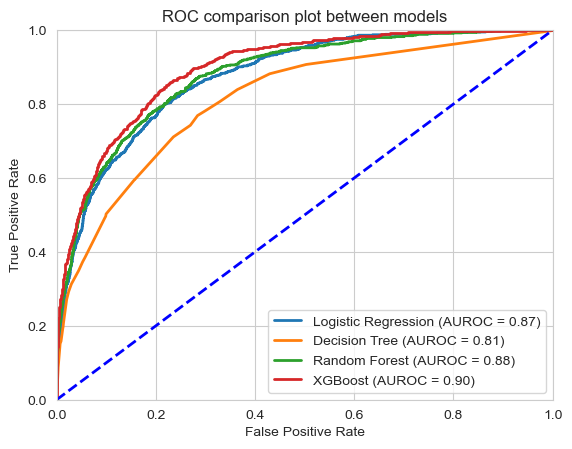

In [131]:
models = [lr, dt, rf, xg]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]

for i, model_ab in enumerate(models):
    fpr, tpr, _ = roc_curve(y_val, models[i].predict_proba(X_val)[:, 1])
    auc_roc = roc_auc_score(y_val, models[i].predict_proba(X_val)[:, 1])
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[i]} (AUROC = {auc_roc:.2f})')
    print(model_names[i])
    Metrics(y_val, models[i].predict(X_val))
    print()

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison plot between models')
plt.legend(loc="lower right")
plt.savefig("comparison.png", dpi=500)
plt.show()